# Cluster Users based on Topics

*This notebook computes topic models from documents and clusters users based on the topics.*

In [1]:
import json
import nlp
from gensim import corpora
from itertools import groupby

import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn import manifold
import matplotlib.cm as cm

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

dataset = 'asm' # lss/asm
input_file = '../data/lss-17k.json'
output_file = '../data/lss-17k-topics.json'

if dataset == 'asm':
    input_file = '../data/lss_asm_dataset.txt'
    output_file = '../data/lss-asm-topics.json'

####  Load data

In [2]:
def load(filename):
    'A text file with each line as a JSON text.'
    p = parse_asm if dataset == 'asm' else parse_lss
    with open(filename) as file:
        sessions = [p(line) for line in file]
    return [s for s in sessions if s]

def parse_asm(text):
    'Return the list of actions from the given JSON text.'
    obj = json.loads(text)
    if 'actions' in obj and obj['actions']:
        action = [a['name'][6:] for a in obj['actions']] #  [6:] to exclude the prefix 'Action'
        return { 'id': obj['session']['dcxID'], 'userId': obj['session']['user']['uid'], 'action': action }

def parse_lss(text):
    'Return the list of actions from the given JSON text.'
    obj = json.loads(text)
    if 'actionsQueue' in obj and obj['actionsQueue']:
        action = [a[6:] for a in obj['actionsQueue']] #  [6:] to exclude the prefix 'Action'
        return { 'id': obj['PFX'], 'action': action, 'userId': obj['userId'] }

In [3]:
data = load(input_file)
docs = [d['action'] for d in data]
for i, d in enumerate(data):
    d['index'] = i

len(data), data[0]

(19351,
 {'action': ['SearchUsr',
   'SearchUsr',
   'DisplayOneUser',
   'UpdateUserDetails',
   'TabBar',
   'SearchUsr',
   'DisplayOneUser',
   'UpdateUserDetails',
   'TabBar',
   'TabBar'],
  'id': '2LK1J5ID313Q1BWKN##NAGHU91',
  'index': 0,
  'userId': 'Fisk, Richard'})

#### Compute topics with LDA

In [ ]:
dictionary = corpora.Dictionary(docs)
corpus = [dictionary.doc2bow(doc) for doc in docs]
lda = nlp.build_lda_with_corpus(corpus, dictionary, num_topics=10)
lda.print_topics()

#### Cluster users
Each user is a vector of tasks 
 - $s = (p_1, p_2, ..., p_{k})$ with $p_i$ is the probability of task $i$
 - $u=\frac{1}{m}\sum_i^{m}{s_i}$ with $s_i$ is the vector representation of tasks for session $i$

In [45]:
data = sorted(data, key=lambda x: x['userId'])
users = groupby(data, key=lambda x: x['userId'])
users = [ { 'userId': k, 'sessions': [s['index'] for s in g] } for k, g in users ]
users[0]

{'sessions': [7314, 11724, 14861], 'userId': "A'lars"}

Get session as vector of topics.

In [46]:
doc_matrix = nlp.get_doc_topic_matrix(lda, corpus)

Get user as mean of session vector of topics

In [48]:
for u in users:
    u['topics'] = np.mean([doc_matrix[s].reshape(1,-1) for s in u['sessions']], axis=0)
    
users[0]

{'sessions': [7314, 11724, 14861],
 'topics': array([[0.11525355, 0.02314815, 0.02314816, 0.0231488 , 0.05823907,
         0.02314829, 0.02314897, 0.02314815, 0.66446871, 0.02314815]]),
 'userId': "A'lars"}

Users as a matrix

In [51]:
user_matrix = np.concatenate([u['topics'] for u in users])
user_matrix.shape

(1422, 10)

Have a look at the users with dimensionality reduction.

In [ ]:
coords = manifold.MDS(random_state=0).fit_transform(user_matrix)

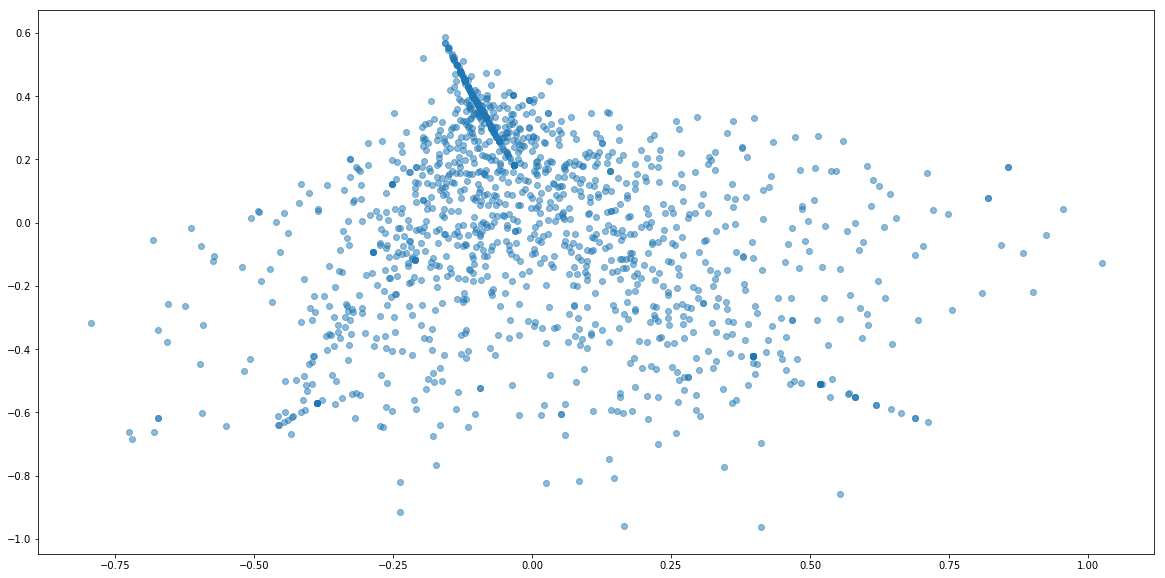

In [54]:
plt.figure(figsize=(20,10))
plt.scatter(coords[:,0], coords[:,1], alpha=0.5)

In [55]:
coords = manifold.TSNE(perplexity=100, random_state=0).fit_transform(user_matrix)

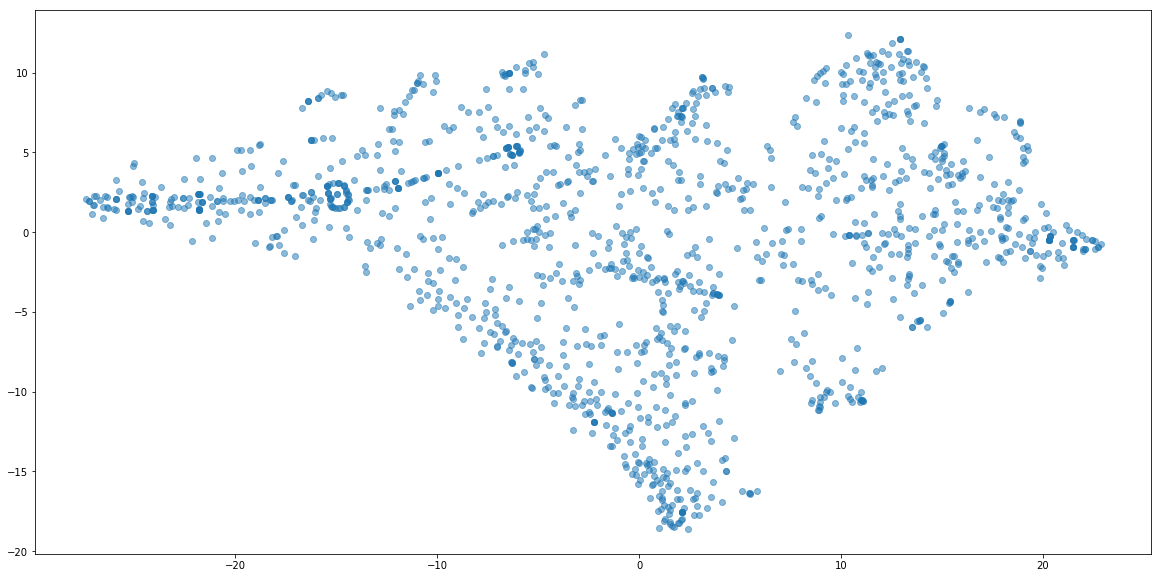

In [56]:
plt.figure(figsize=(20,10))
plt.scatter(coords[:,0], coords[:,1], alpha=0.5)

In [69]:
ss = []
K = range(1, 50)
for k in K:
    km = KMeans(n_clusters=k, random_state=0)
    km = km.fit(user_matrix)
    ss.append(km.inertia_)

Text(0.5,1,'Elbow Method For Optimal k')

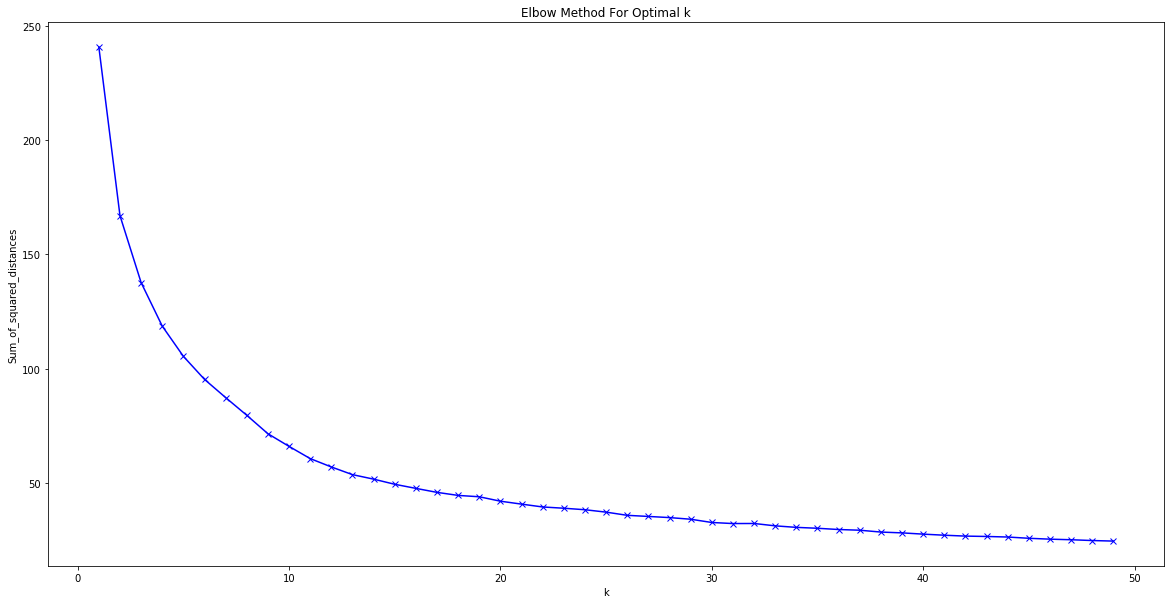

In [70]:
plt.figure(figsize=(20,10))
plt.plot(K, ss, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')

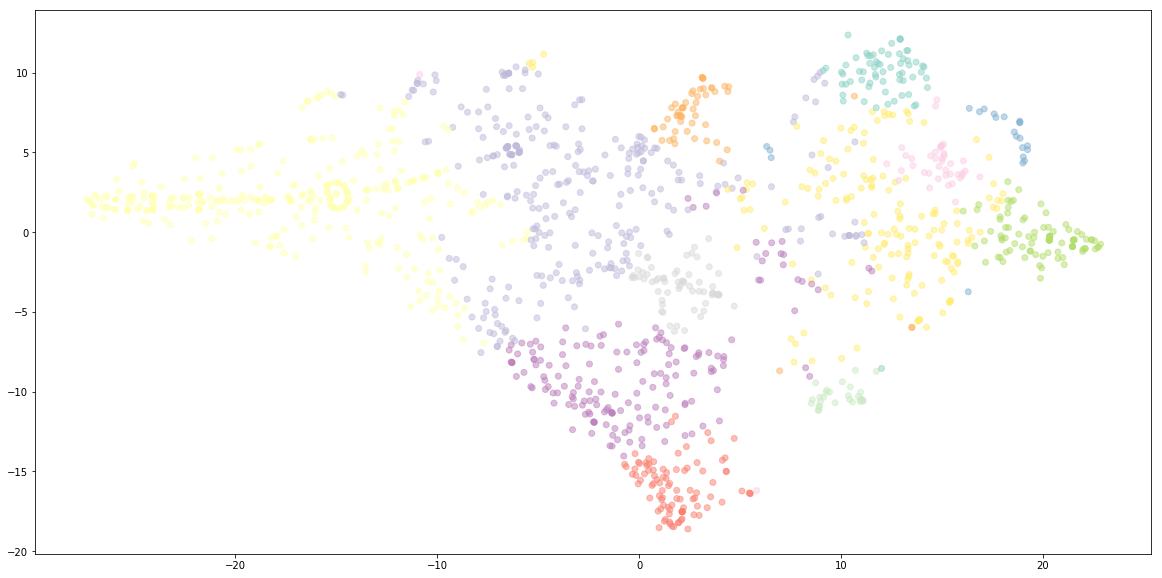

In [85]:
coords = manifold.TSNE(perplexity=100, random_state=0).fit_transform(user_matrix)
km = KMeans(n_clusters=12, random_state=0)
labels = km.fit_predict(user_matrix)
plt.figure(figsize=(20,10))
plt.scatter(coords[:,0], coords[:,1], alpha=0.5, c=labels, cmap=plt.cm.get_cmap('Set3'))

3 0.3356649711389394
4 0.33436627287815657
5 0.3275260857399197
6 0.3329878325972984
7 0.32871672720142153
8 0.29724374010645516
9 0.30924625736014466
10 0.29712202412138555
11 0.303617540090902
12 0.3065682675844481
13 0.3059734605298261
14 0.30245228515615635
15 0.2918342633053994
16 0.2889828678226767
17 0.2696359439376437
18 0.2840615574098194
19 0.25123728025801695
20 0.27435015304077026
21 0.27026161942991644
22 0.24970473833153112
23 0.24963450137151497
24 0.26952056025560095
25 0.2570281937944224
26 0.25867648019059386
27 0.2624946956423544
28 0.2542416564619529
29 0.2541524173217928
30 0.2623352401723378
31 0.2658091379899297
32 0.2610712255867339
33 0.2637563026093036
34 0.26379896215873505
35 0.26282394433786715
36 0.26369393266963465
37 0.25186530715502403
38 0.2726474530417058
39 0.274062988257263


Text(0.5,1,'Elbow Method For Optimal k -- silhouette_avg')

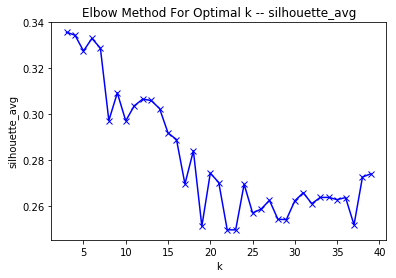

In [65]:
ss = []
K = range(3, 40)
for k in K:
    km = KMeans(n_clusters=k, random_state=0)
    labels = km.fit_predict(user_matrix)
    silhouette_avg = silhouette_score(user_matrix, labels)
    print(k, silhouette_avg)
    ss.append(silhouette_avg)
    
plt.plot(K, ss, 'bx-')
plt.xlabel('k')
plt.ylabel('silhouette_avg')
plt.title('Elbow Method For Optimal k -- silhouette_avg')

For n_clusters = 3 The average silhouette_score is : 0.3355012669959284
For n_clusters = 4 The average silhouette_score is : 0.3306638906770559
For n_clusters = 5 The average silhouette_score is : 0.31731829264017253
For n_clusters = 6 The average silhouette_score is : 0.33342173865219005
For n_clusters = 7 The average silhouette_score is : 0.28235145793599364
For n_clusters = 8 The average silhouette_score is : 0.3296213279622288
For n_clusters = 9 The average silhouette_score is : 0.3157539443031904
For n_clusters = 10 The average silhouette_score is : 0.29612552646494034
For n_clusters = 11 The average silhouette_score is : 0.3039783687153682
For n_clusters = 12 The average silhouette_score is : 0.30258350611801577
For n_clusters = 13 The average silhouette_score is : 0.3124341506676114
For n_clusters = 14 The average silhouette_score is : 0.28952775508247447
For n_clusters = 15 The average silhouette_score is : 0.2883188297920876
For n_clusters = 16 The average silhouette_score is 

/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


For n_clusters = 23 The average silhouette_score is : 0.27049065129425864


/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


For n_clusters = 24 The average silhouette_score is : 0.26792854472022726


/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


For n_clusters = 25 The average silhouette_score is : 0.2568369708024047


/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


For n_clusters = 26 The average silhouette_score is : 0.26872605172481245


/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


For n_clusters = 27 The average silhouette_score is : 0.25994616594122405


/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


For n_clusters = 28 The average silhouette_score is : 0.2576914224716029


/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


For n_clusters = 29 The average silhouette_score is : 0.26321681286282034


/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


For n_clusters = 30 The average silhouette_score is : 0.26006259073909993


/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


For n_clusters = 31 The average silhouette_score is : 0.26457321977046144


/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


For n_clusters = 32 The average silhouette_score is : 0.26292510217995146


/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


For n_clusters = 33 The average silhouette_score is : 0.26320079870040314


/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


For n_clusters = 34 The average silhouette_score is : 0.26815281261089063


/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


For n_clusters = 35 The average silhouette_score is : 0.2661700626680178


/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


For n_clusters = 36 The average silhouette_score is : 0.26135993975678656


/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


For n_clusters = 37 The average silhouette_score is : 0.26923265852779205


/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


For n_clusters = 38 The average silhouette_score is : 0.265880018233157


/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


For n_clusters = 39 The average silhouette_score is : 0.27290041013370137


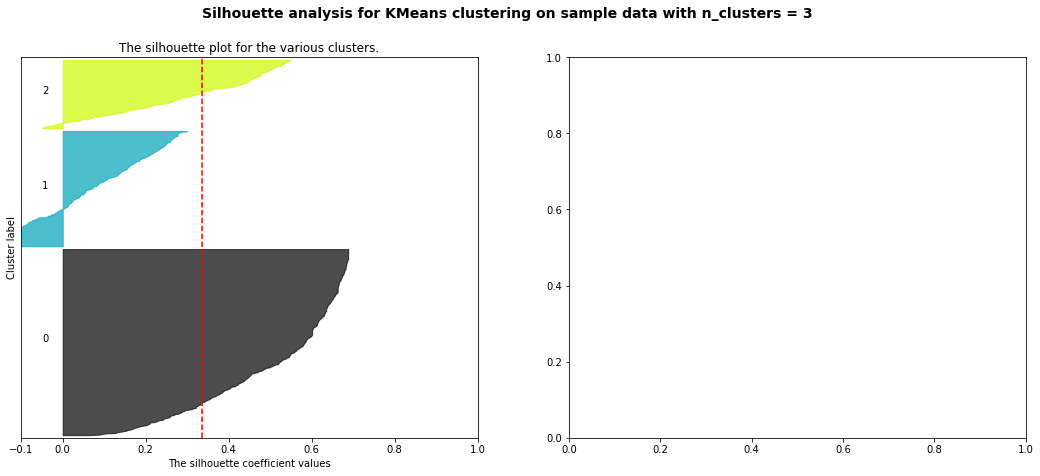

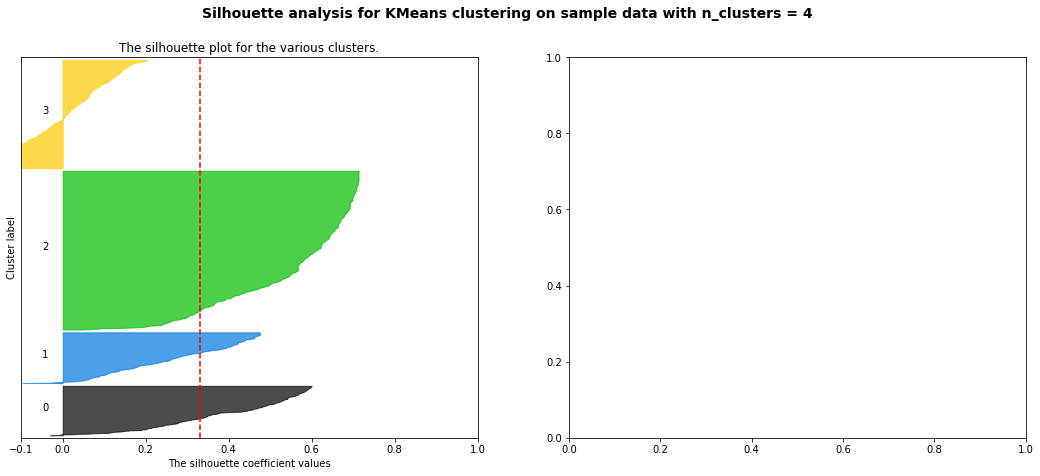

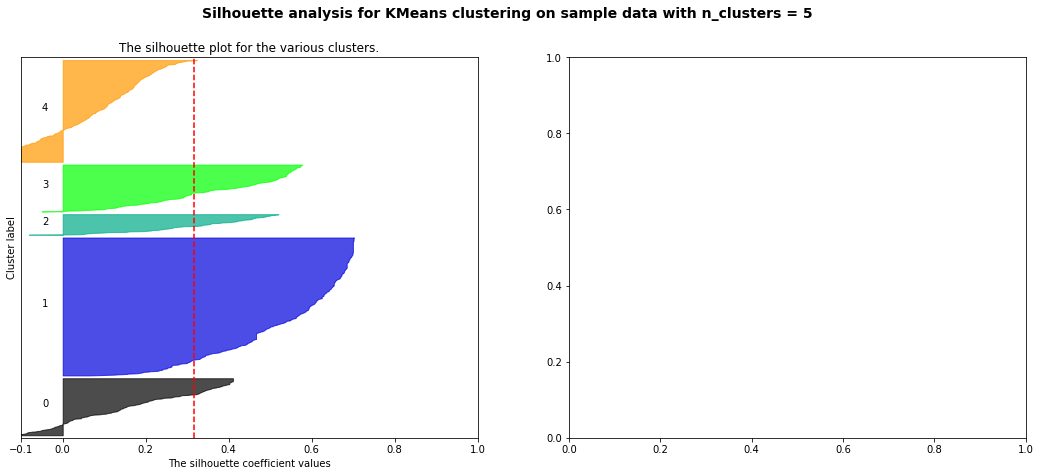

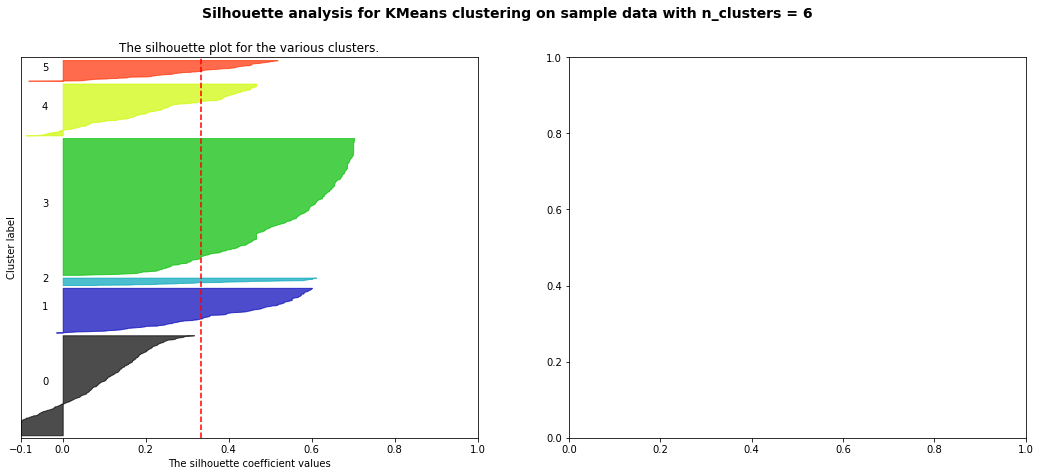

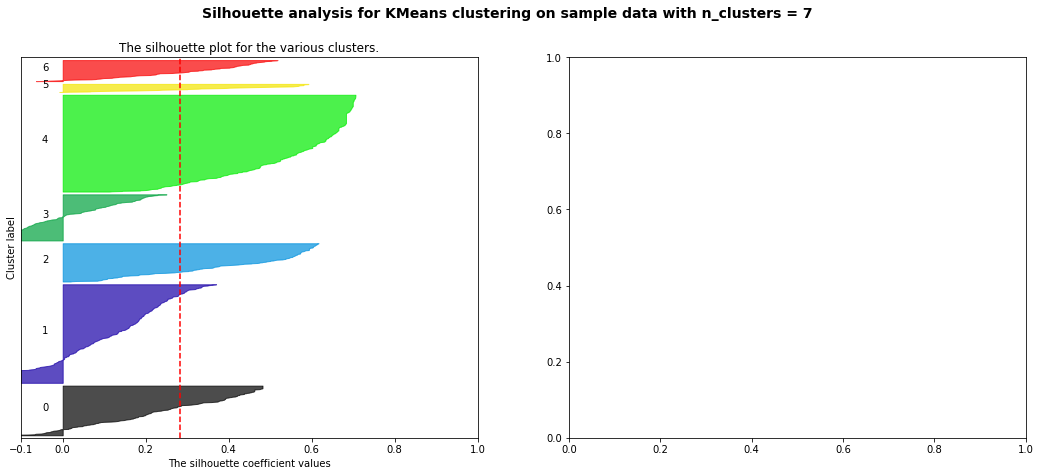

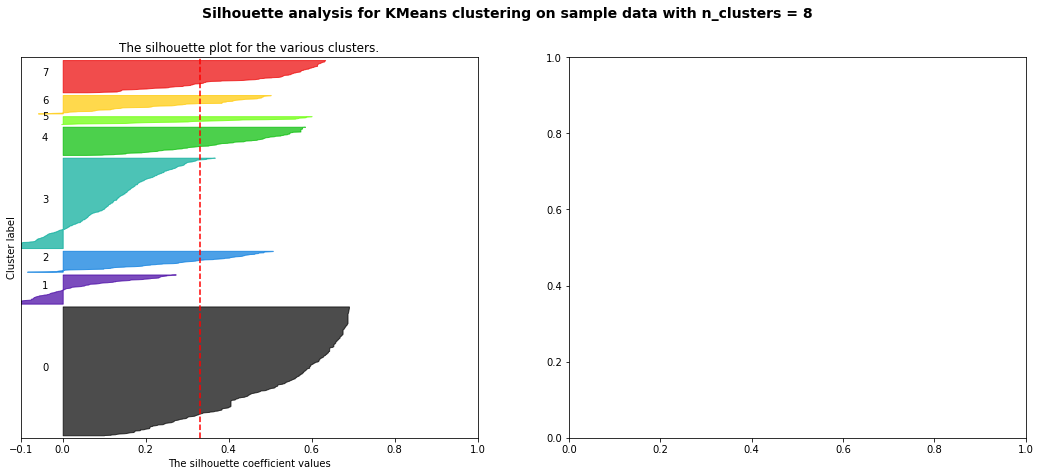

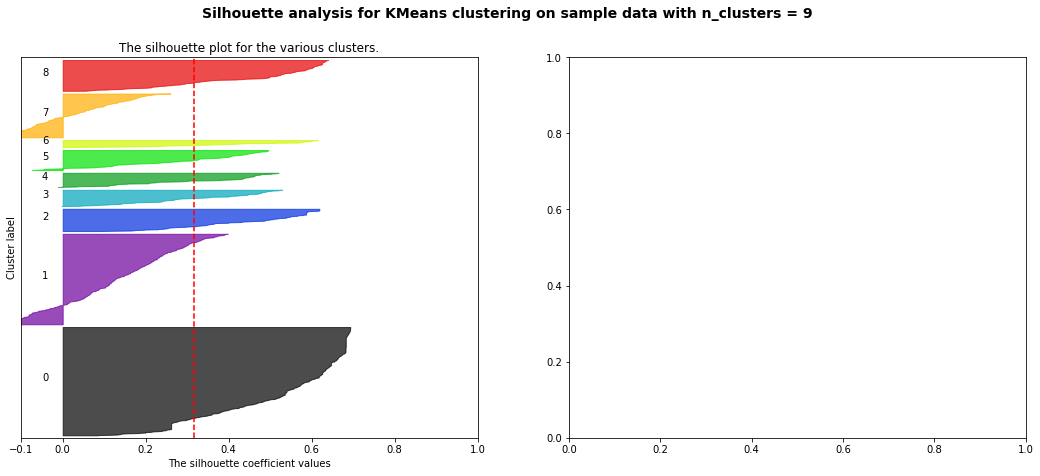

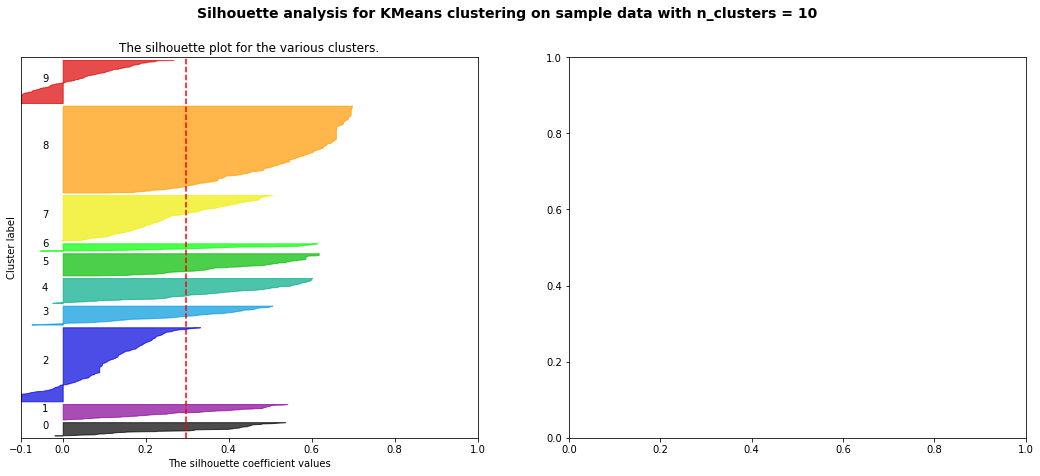

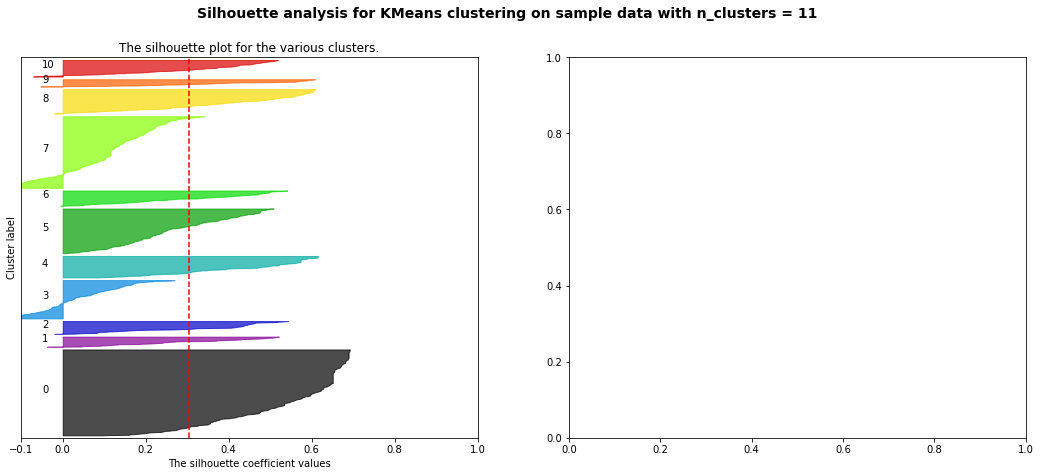

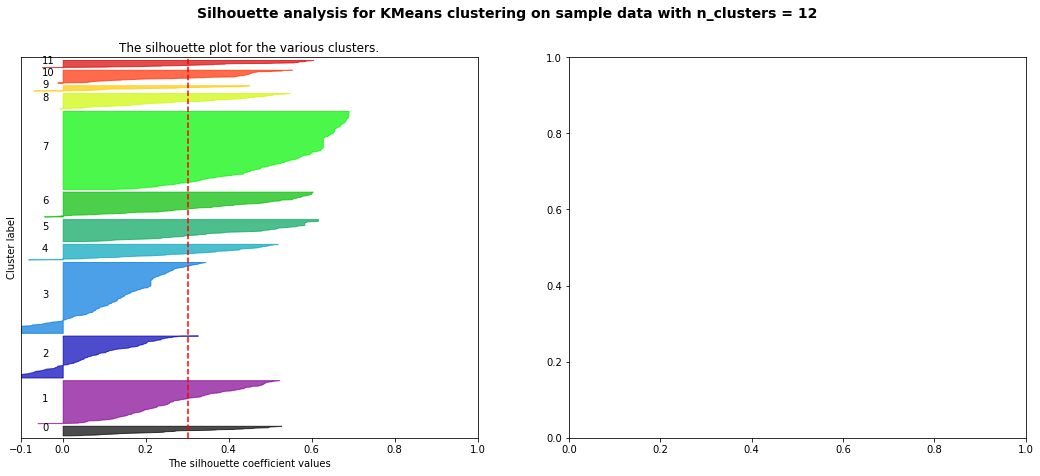

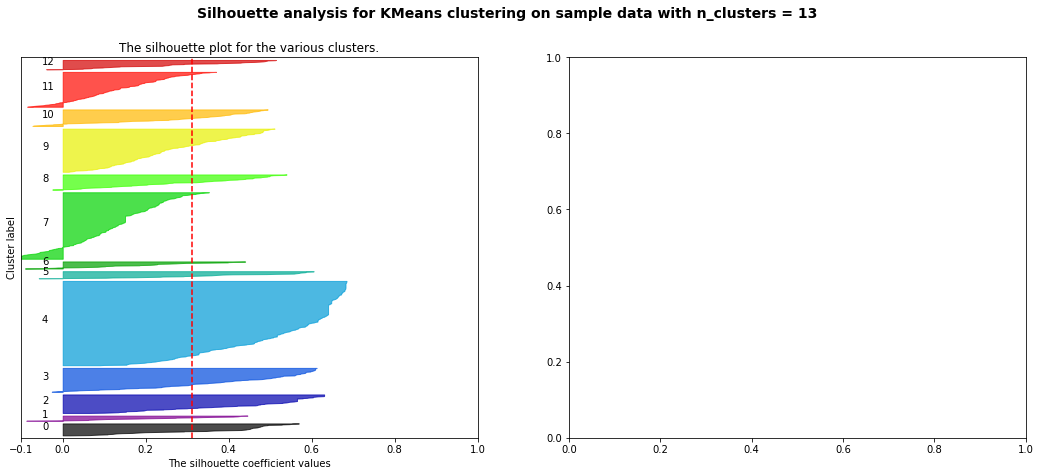

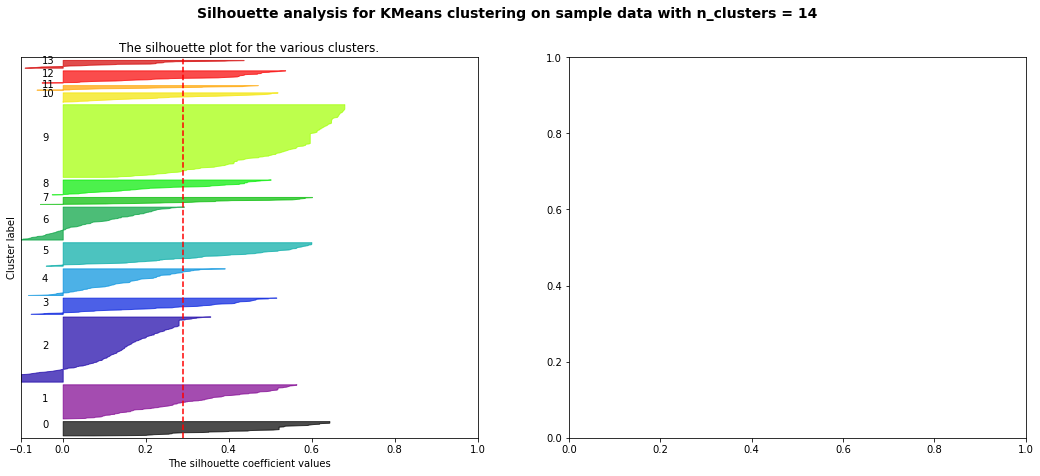

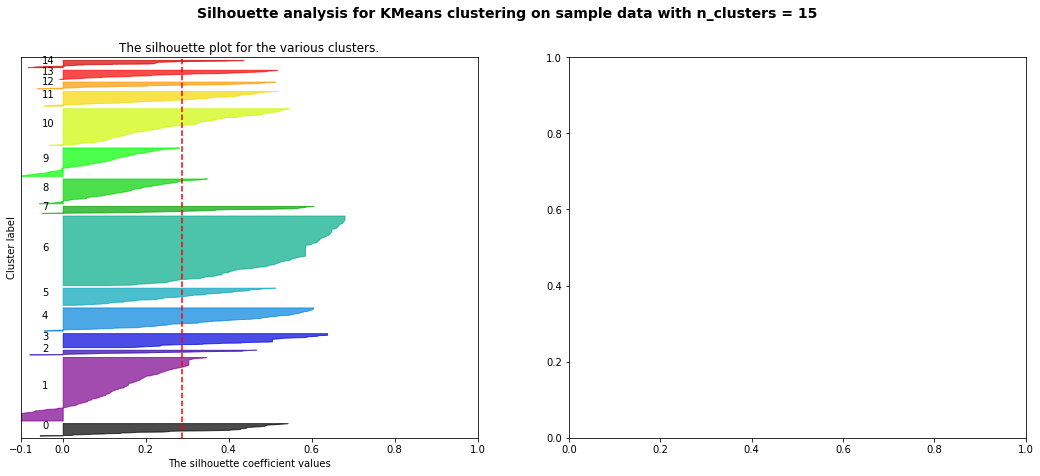

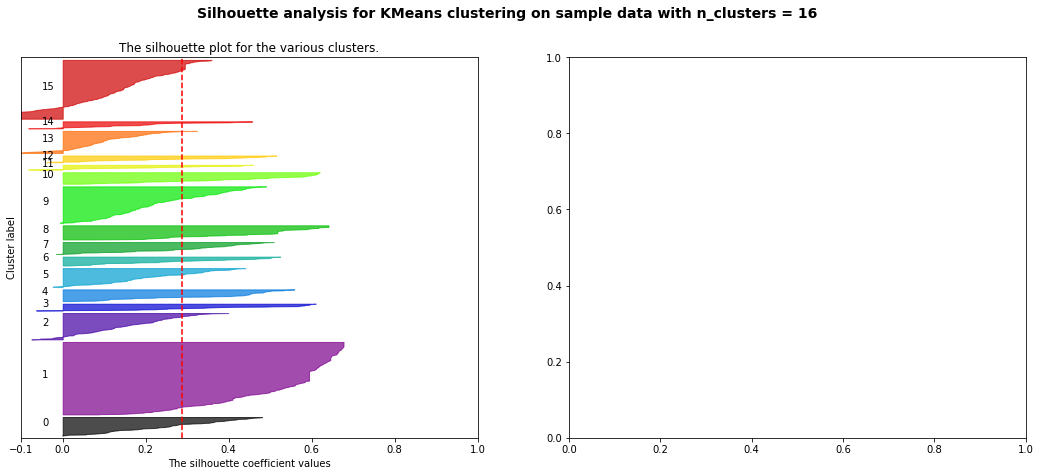

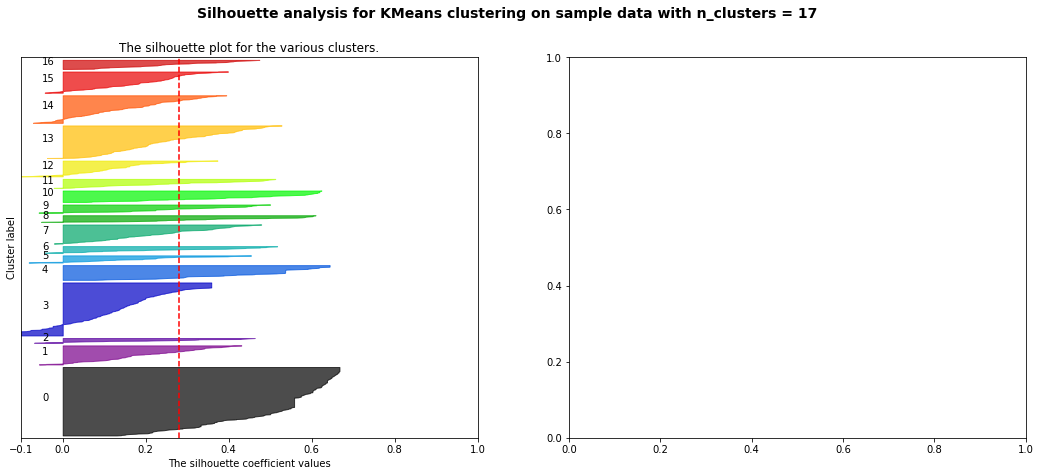

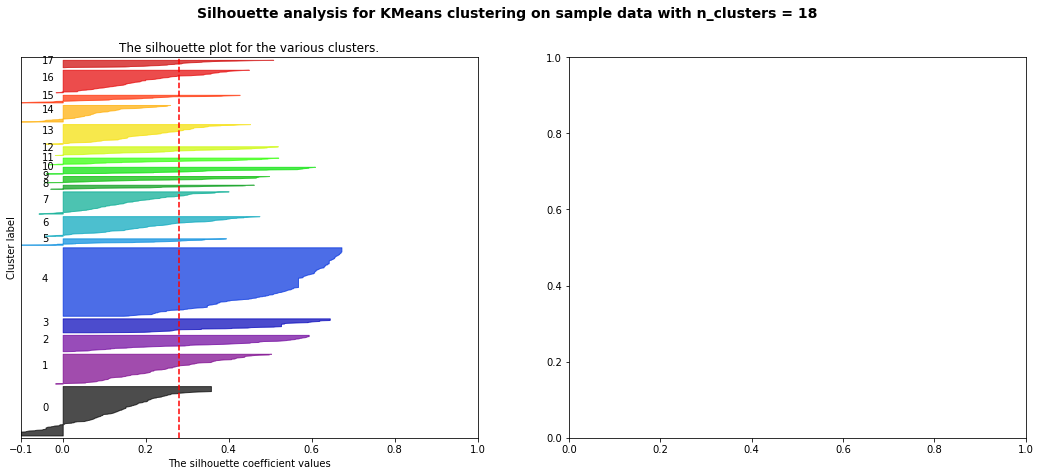

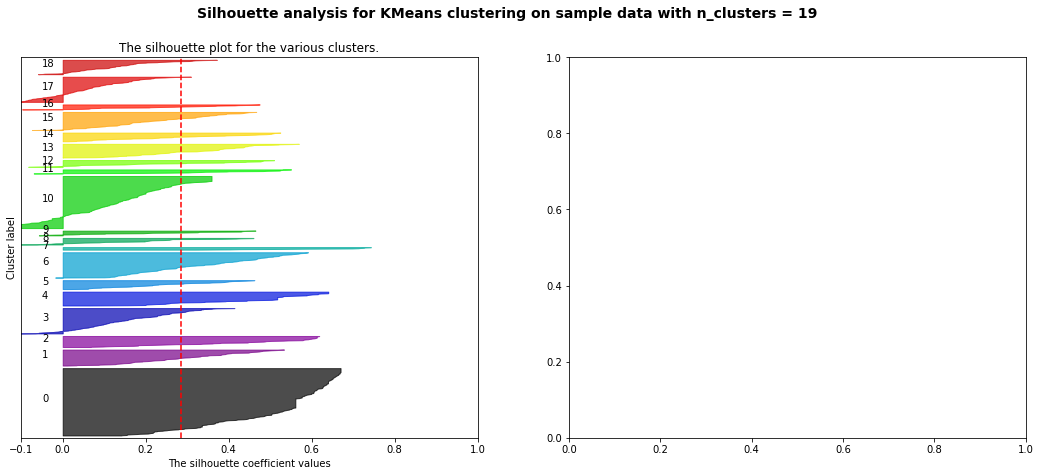

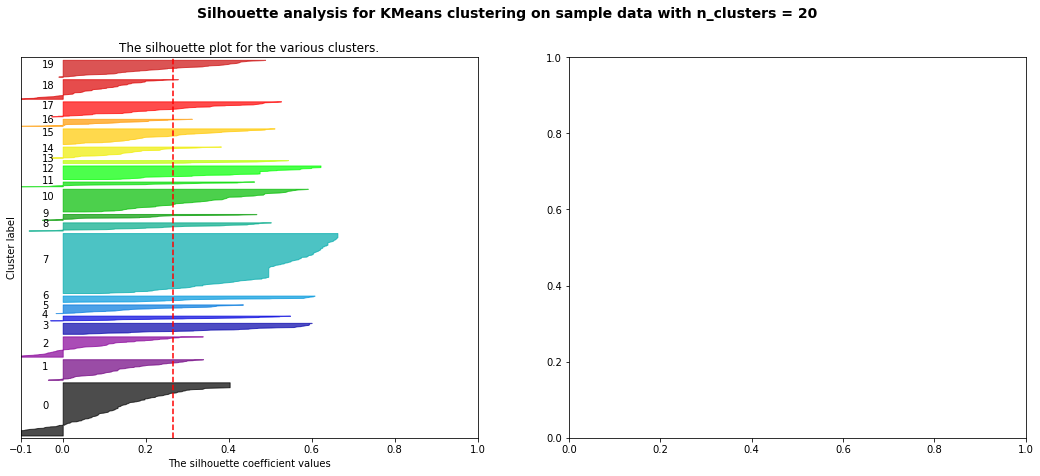

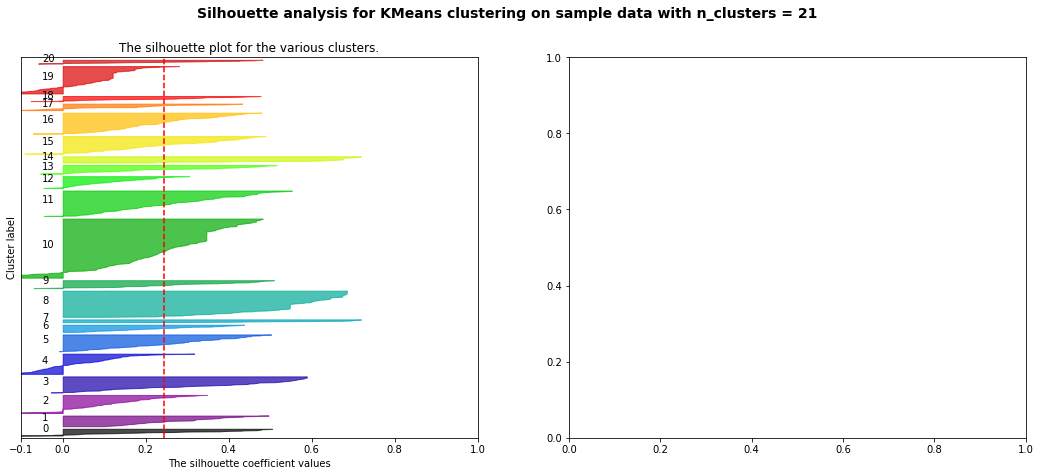

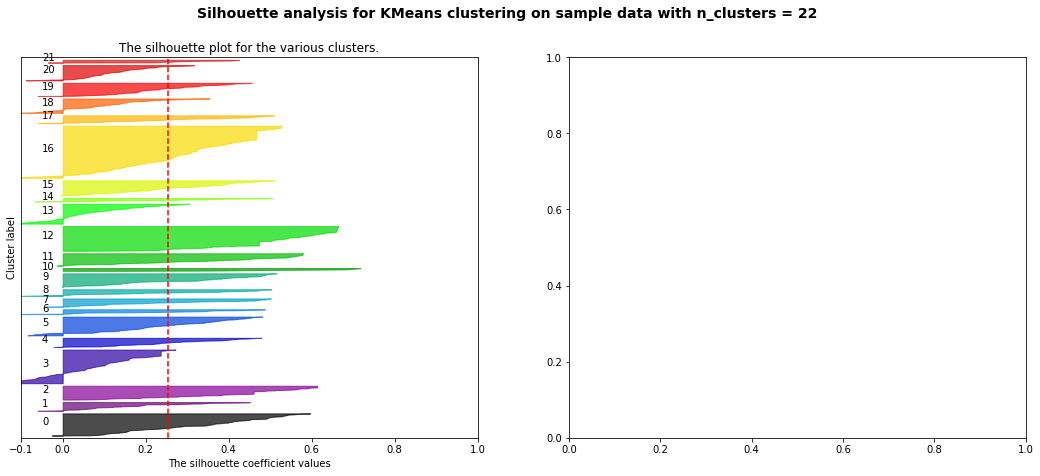

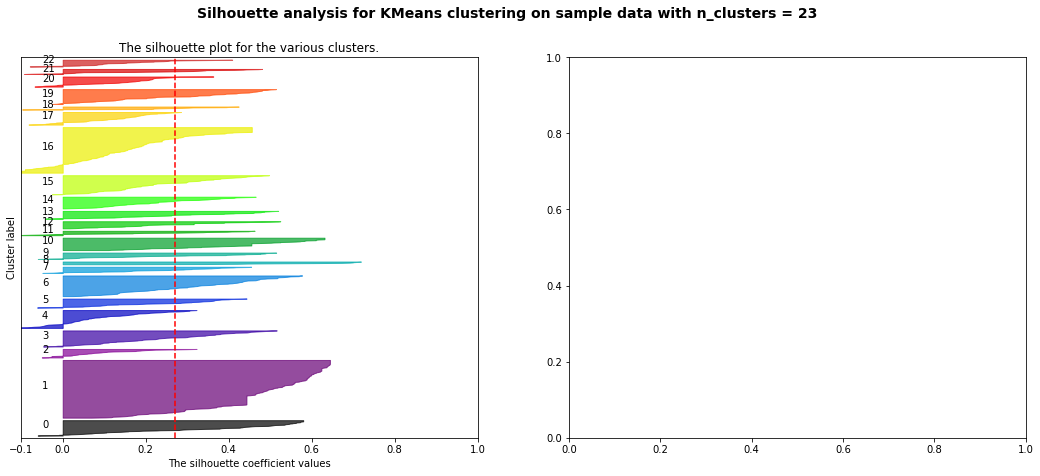

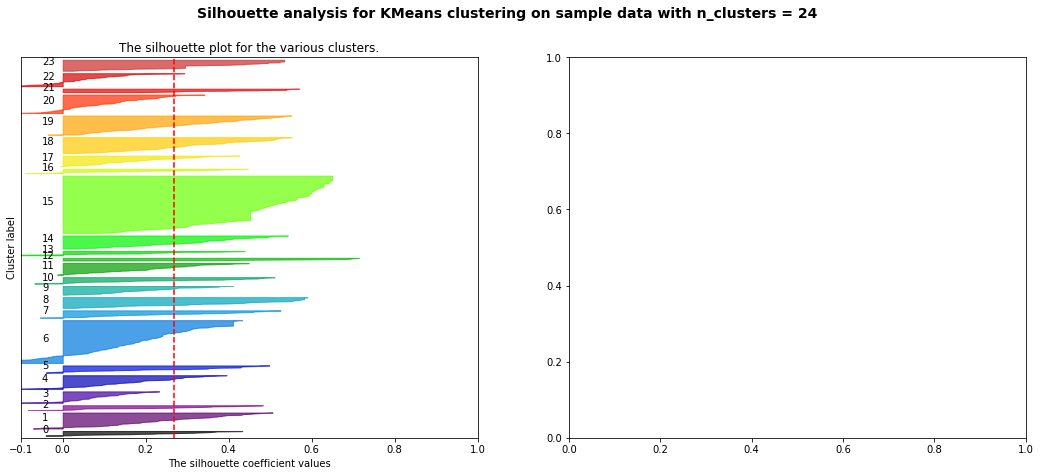

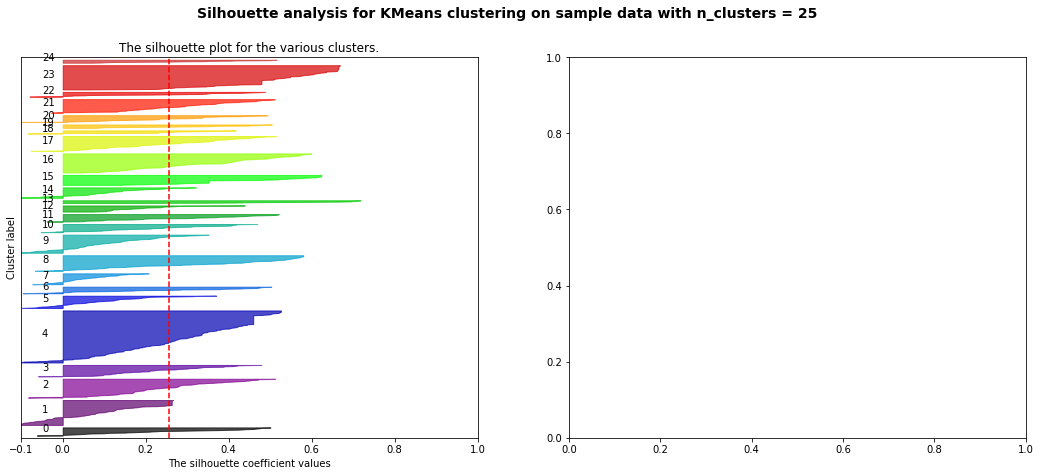

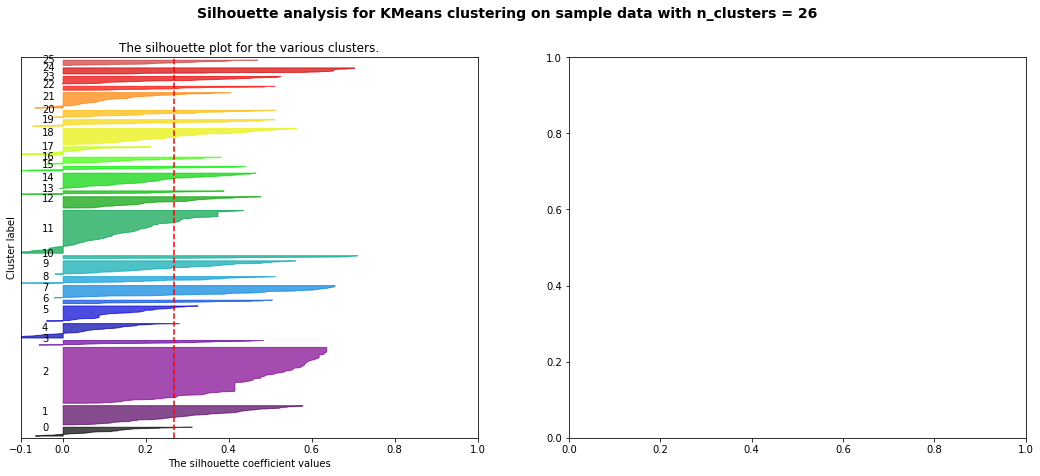

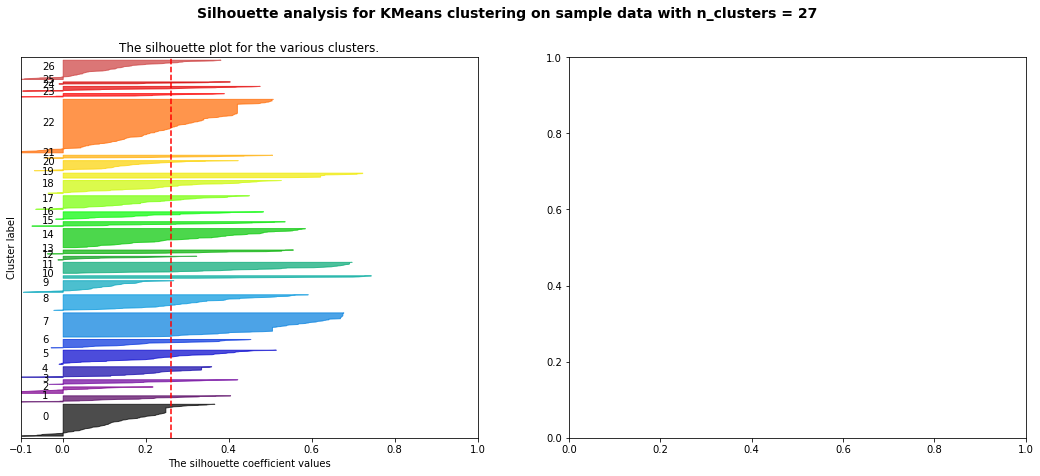

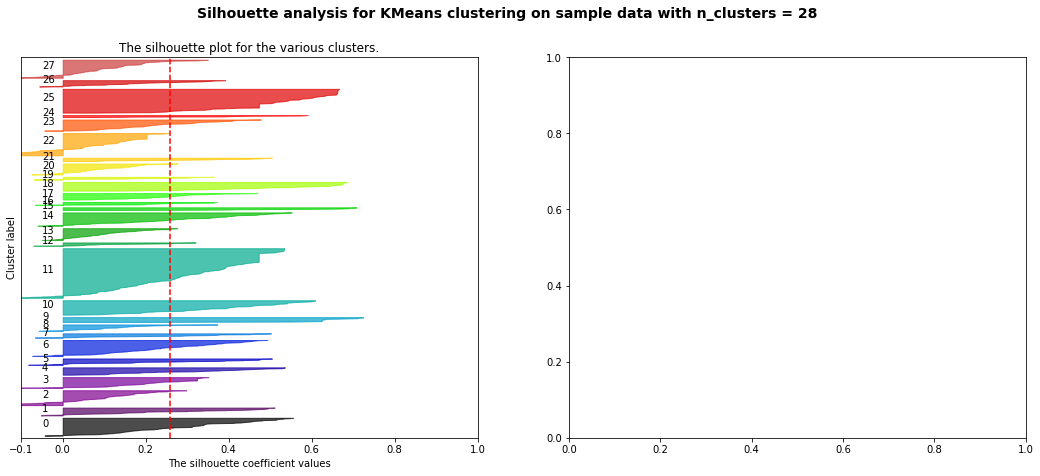

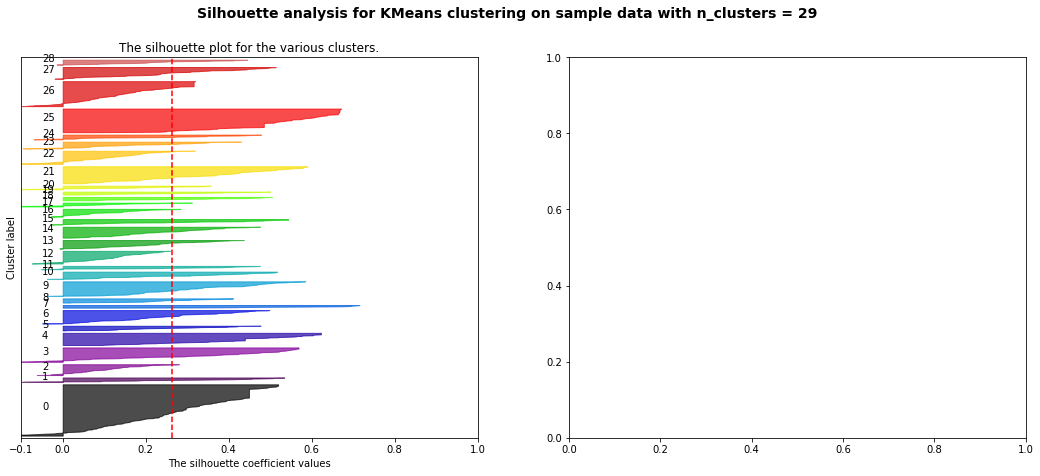

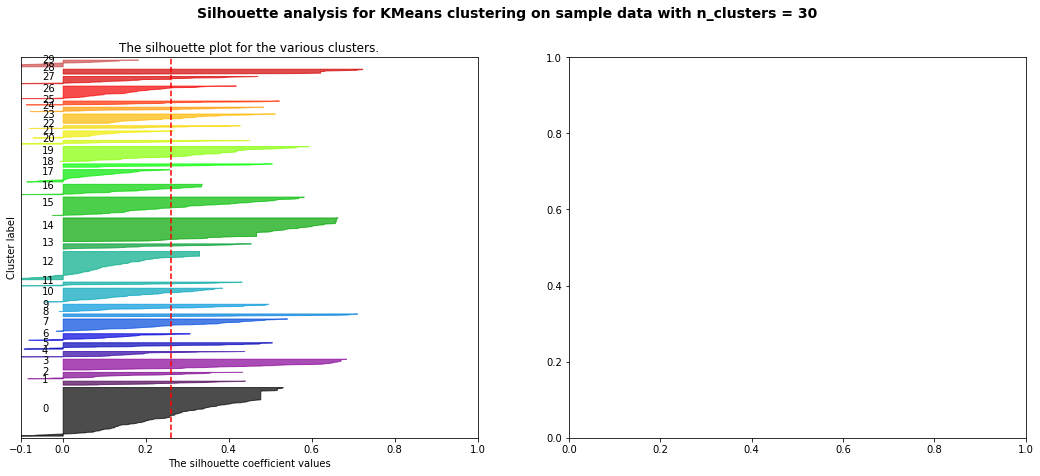

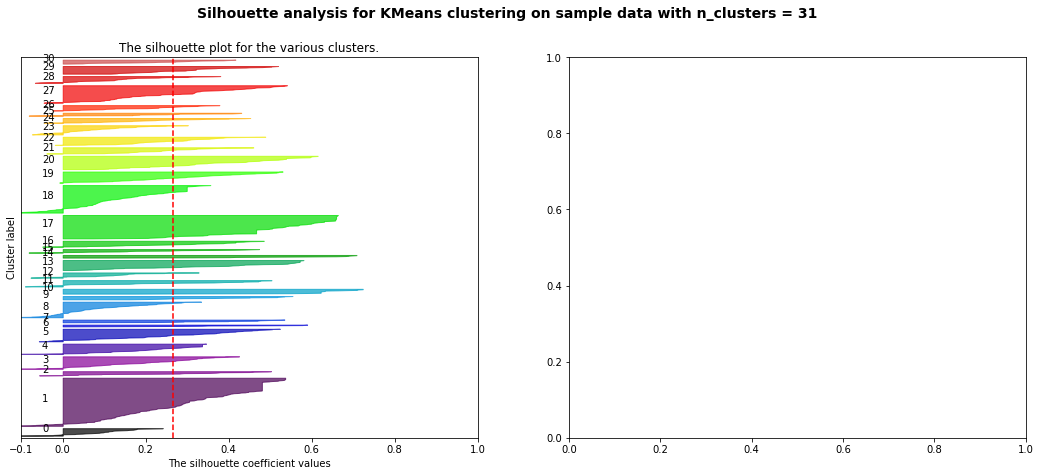

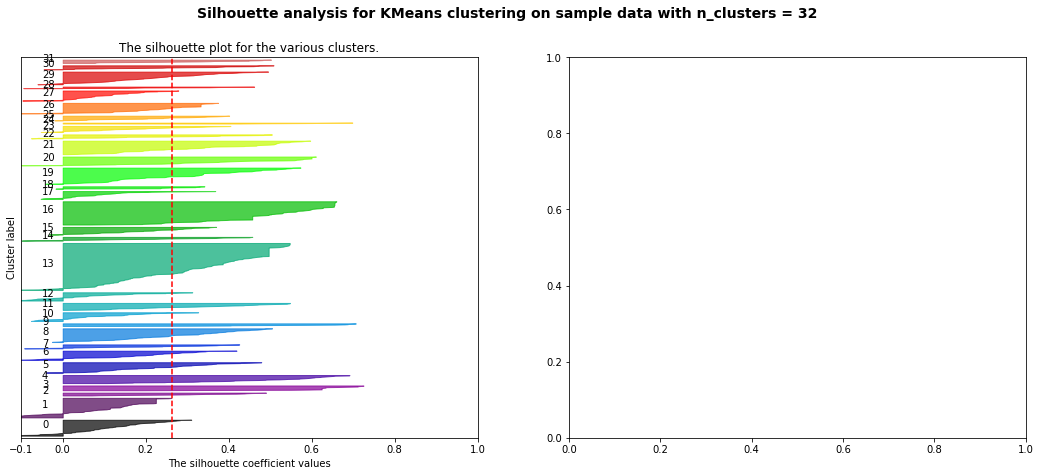

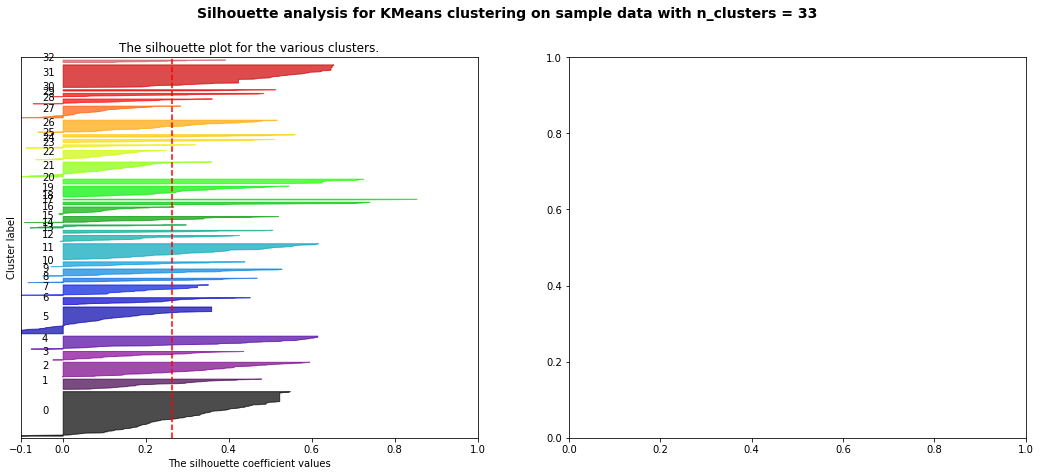

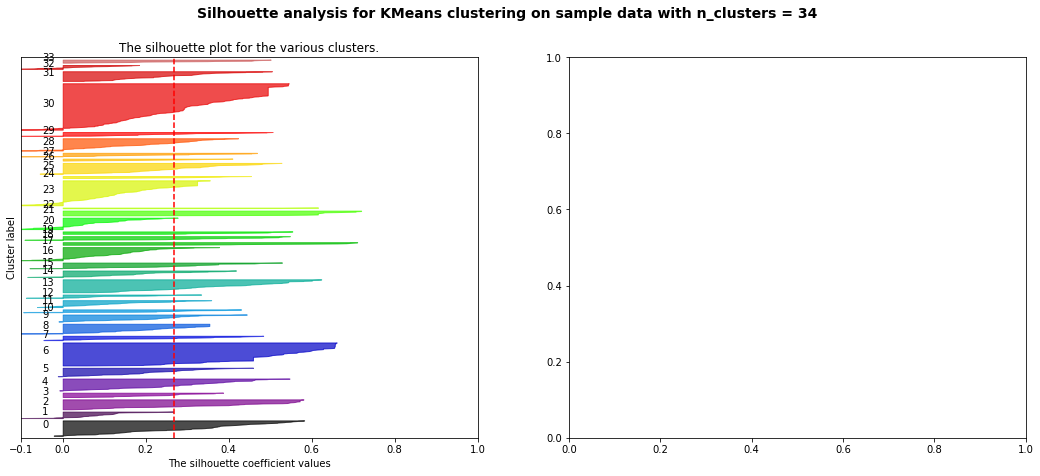

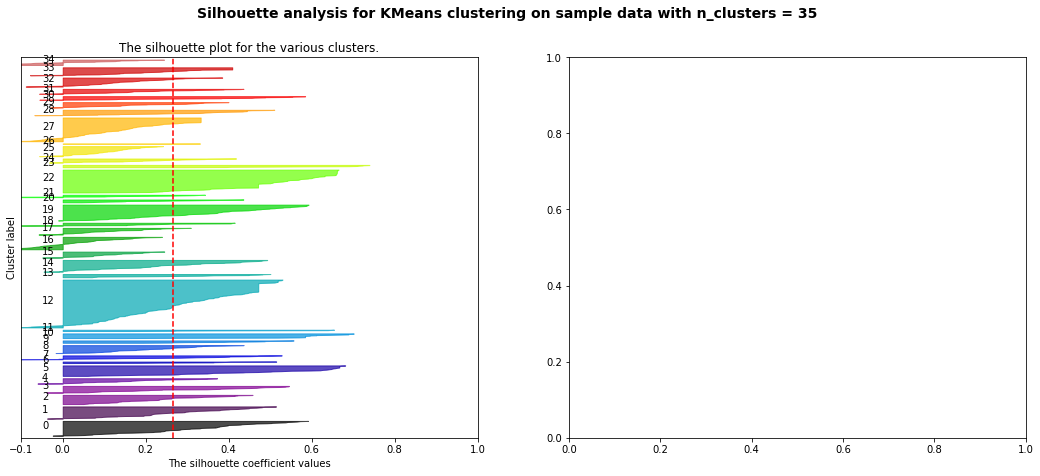

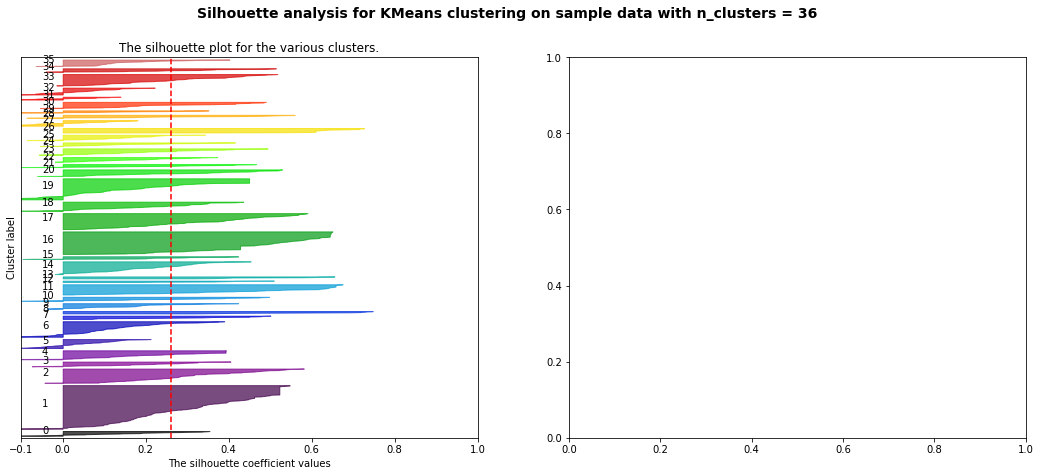

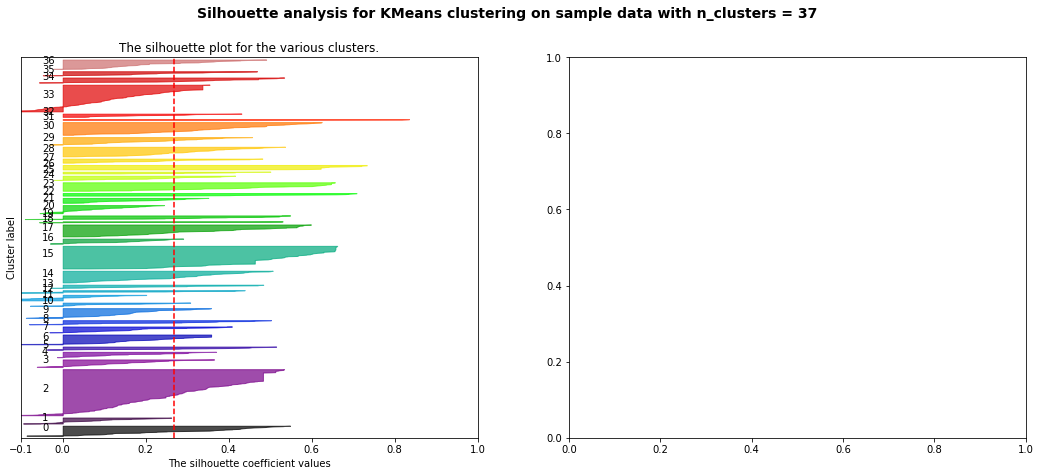

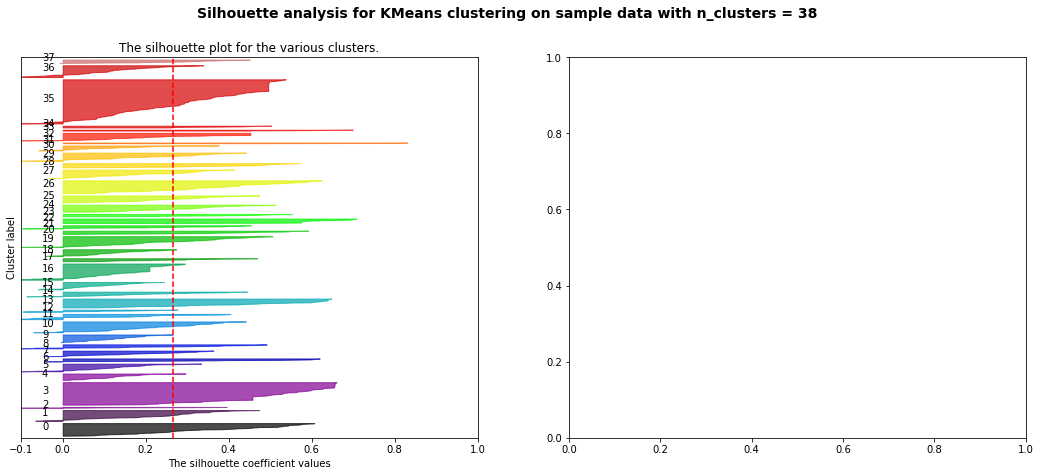

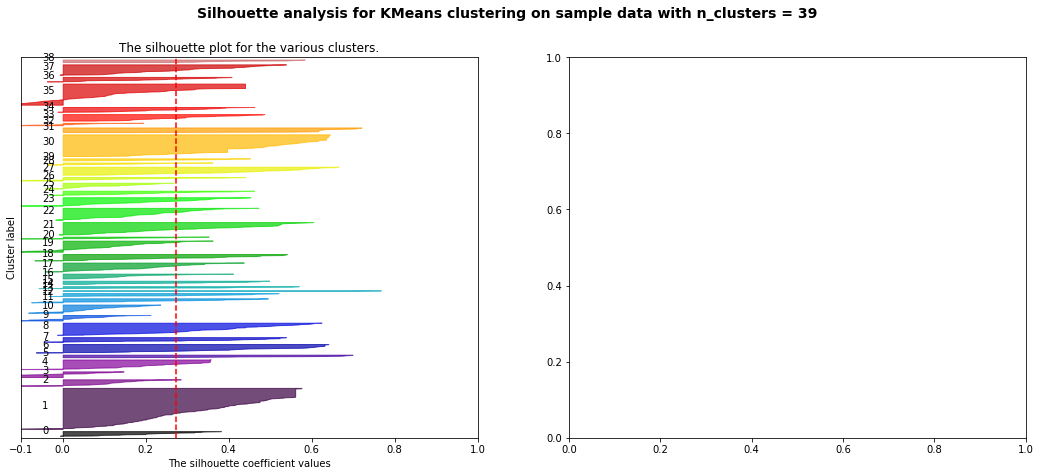

In [66]:
range_n_clusters = range(3,40)
matrix = user_matrix

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(matrix) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(matrix)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(matrix, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(matrix, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

#     # 2nd Plot showing the actual clusters formed
#     colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
#     ax2.scatter(coords[:, 0], coords[:, 1], marker='.', s=30, lw=0, alpha=0.7,
#                 c=colors, edgecolor='k')

#     # Labeling the clusters
#     centers = clusterer.cluster_centers_
#     # Draw white circles at cluster centers
#     ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
#                 c="white", alpha=1, s=200, edgecolor='k')

#     for i, c in enumerate(centers):
#         ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
#                     s=50, edgecolor='k')

#     ax2.set_title("The visualization of the clustered data.")
#     ax2.set_xlabel("Feature space for the 1st feature")
#     ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

Quite messy code now, let's have a data frame for user matrix.

In [122]:
df = pd.DataFrame(user_matrix)
df['cluster'] = labels
cluster_matrix = df.groupby('cluster').mean().values

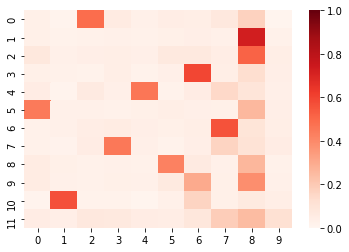

In [124]:
sns.heatmap(cluster_matrix, vmin=0, vmax=1, cmap='Reds')

#### Export data

In [39]:
with open(output_file, 'w') as f:
    json.dump({ 'topics': all_topics, 'sessions': output_data }, f)